# Project: ISIC Dataset classifier

This project builds a classifier for malignant or benign skin anomalies using the images, age, and sex information. The objective is to make a classifier that will allow for screening of patients before actual tests are needed. This is so that there isnt multiple unnecessary testing when tests are so expensive can also result in false positives. 

In [1]:
# load dependencies
import keras
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.models import load_model
from imageio import imread
random.seed(42)

# custom python files
import evaluate
import generator
import model

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Section 1: Data set
This section shows examples of the data

In [2]:
def plot_images(images, save_fig=False, labels=None, filename='img.png'):
    """
    This function is built to take in a perfect square number of images 
    to display them in a n x n grid along with their corresponding labels
    """
    grid_size = int(np.sqrt(len(images)))
    plt.figure(figsize=(10,10))
    for x in range(grid_size):
        for y in range(grid_size):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_size, grid_size))
            plt.subplot(grid_size, grid_size, lin_ind+1)
            currImg = images[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            if labels is not None:
                plt.title(labels[y*3+x])
            plt.imshow(currImg)
            plt.gca().axis('off')
    if save_fig:
        plt.savefig(filename)
    plt.show()

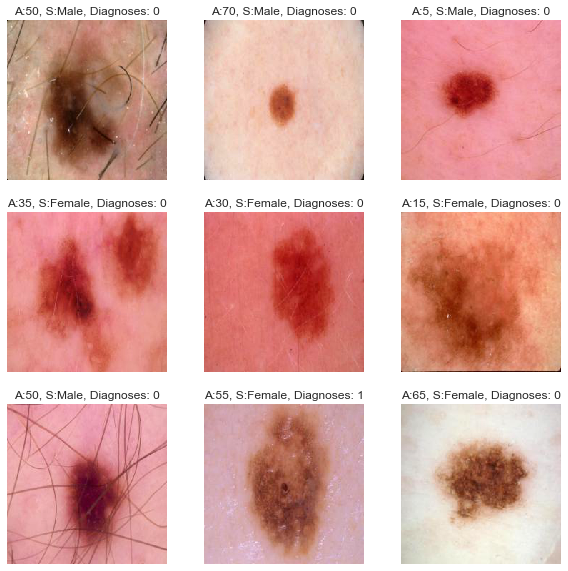

In [3]:
# display the eg data along with corresponding tags
TRAIN_DIR = "../Data/train/"
VALIDATION_DIR = "../Data/val/"
TEST_DIR = "../Data/test/"

test_img_names = os.listdir(TEST_DIR) 
random.shuffle(test_img_names)
    
images = []
labels = []
for img_name in test_img_names[:9]:
    img = imread(TEST_DIR + img_name)
    img_info = img_name.split(",")
    sex = "Male" if img_info[2] == "1" else "Female"
    
    img = img/255
    images.append(img)
    labels.append("A:" + img_info[1] + ", S:" + sex + ", Diagnoses: " + img_info[0])


plot_images(images, labels=labels)

### Section 2: Model Architecture
This section will show and discuss the architecture of relevant models. 
I created 2 models for this project. The first one using the image as well as the age and sex information. The second only uses the image. This lets us see the impact of the non-visual information available.


![](model_architecture.png)

In [4]:
# load model
cnn_model = load_model("../Models/cnn_only_model_at_012.h5")
mixed_model = load_model("../Models/mixed_model_at_012.h5")

As we see below, the model takes the vector representation created by feeding the image through all but the last 3 layers of VGG16, and passes that through an MLP to reach a diagnosis.

In [5]:
# print model architecture
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

The Mixed model below uses the VGG16 Model, removing the top 3 layers. The model concatenates the vector output of the VGG16 model with the vector output of an MLP for the Age and Sex information. We then run this new extended feature vector through an MLP to make a diagnoses.

In [6]:
# print model architecture
mixed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

### Section 3: Analysis of Results

In [7]:
# develop confusion matrices, calculate specificity, etc

# create generators
cnn_train_generator = generator.Data_Gen_CNN(TRAIN_DIR, 1000)
mixed_train_generator = generator.Data_Gen(TRAIN_DIR, 1000)

cnn_validation_generator = generator.Data_Gen_CNN(VALIDATION_DIR, 400)
mixed_validation_generator = generator.Data_Gen(VALIDATION_DIR, 400)

cnn_test_generator = generator.Data_Gen_CNN(TEST_DIR, 400)
mixed_test_generator = generator.Data_Gen(TEST_DIR, 400)



# create confusion matrices
print("----------- Analysis of CNN Model Results -----------")
evaluate.print_confusion_matrix(cnn_model, cnn_train_generator, "CNN Model on Train Data")
evaluate.print_confusion_matrix(cnn_model, cnn_validation_generator, "CNN Model on Validation Data")
evaluate.print_confusion_matrix(cnn_model, cnn_test_generator, "CNN Model on Test Data")

print("----------- Analysis of Mixed Model Results -----------")
evaluate.print_confusion_matrix(mixed_model, mixed_train_generator, "Mixed Model on Train Data")
evaluate.print_confusion_matrix(mixed_model, mixed_validation_generator, "Mixed Model on Validation Data")
evaluate.print_confusion_matrix(mixed_model, mixed_test_generator, "Mixed Model on Test Data")


----------- Analysis of CNN Model Results -----------
Confusion Matrix for CNN Model on Train Data is:
[[788   0]
 [  0 212]]
Classification Report for CNN Model on Train Data is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       788
           1       1.00      1.00      1.00       212

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix for CNN Model on Validation Data is:
[[300  27]
 [ 41  32]]
Classification Report for CNN Model on Validation Data is:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       327
           1       0.54      0.44      0.48        73

    accuracy                           0.83       400
   macro avg       0.71      0.68      0.69       400
weighted avg       0.82      0.83      0.82       400

Confusion Matrix for CNN Model

There is a lot to be infered from the results above. 

- Firstly, we see that the accuracy is significantly higher than the baseline accuracy of the data. That is, if the model was only to predict the most popular class, the resulting accuracy would be about 81%. This means that using the data available, the model is actually able to gain an understanding into which moles are benign and which malignant. 

- Using two models, one with, and one without the use of age and sex data helps us analyze the use of the age or sex of the patient (that is only diagnosing old patients as malignant). 

- What is interesting is that the CNN only model seems to generalize better than the one that includes the age and sex data in our case, allowing it to perform better on Validation and Test data when it performs worse on the train data (took significantly longer to reach accuracy of 1.000 while training, and performed worse on train data in previous tests).

- The models used a data set that did not contain 50-50 data. This makes it tougher to understand the implication of the accuracy and this is why we will analyze other metrics such as Specificity and Sensitivity. The benefit of this is that the model is getting an untampered sample of the real world data (about 80-20 ratio of patients reaching the imaging position) and we do not have to waste valuable data that the model can improve from.

- "Sensitivity measures how often a test correctly generates a positive result for people who have the condition that’s being tested for." The test sensitivity of our better model is 0.52, this is close to guessing.

- "Specificity measures a test’s ability to correctly generate a negative result for people who don’t have the condition that’s being tested for." The test specificity of our better model is 0.96

From these results, we see that the model is very good at telling when people are true negatives, this means that the model is useful to rule in patients. That is, if a patient recieves a positive result to a previous test, this test can help confirm that it was not a false positive. 
Thus if a patient is suspicious of their mole after using something such as the ABCDE test (checking for assymetry, border, color, diameter, and evolution, the model would do well to rule in a patient.

### Section 4: Project Discussion
The problem is a difficult one. Most untrained eyes cannot reach a high Sensitivity or Specificity. This makes the fact that the model is able to improve from the baseline using only the visual data impressive. However, the mixed data seems to have hindered the results of the model. Thus the best results are using only the visual data. 

The best ways to increase the accuracy of the model would be to increase the amount of data the model learns from. Another significant improvement wolud be to augment the models input features relating more closely to features that are used by human doctors to diagnose these issuses, like removing hair from the images, or adding an emphasis on the mask of the mole to allow for the model to learn the shapes of the moles.  

A few ideas to improve the model in the future would be to:

##### Fine tune the model
The models subsequent layers should be retrained for 1-2 epochs since the last few layers of VGG16 might be more inclined to detecting larger and significantly different structures than needed by our model, missing out on other nuances.

##### Improve the MLP
The fact that the mixed data using model performs worse than the CNN only model makes one consider changing the structure and experimenting to see what would improve the use of this data. Some ideas for these improvements include: Smaller structure, increased dropout, binned inputs, and normalization for inputs. All these would need to be tried to get a better idea of the required changes.

##### Use different pre-trained models
The model can be tried after using different pre-trained models. Using a lighter model, we would be able to create a significantly faster model. However, my attempts of using ResNetV2 and InceptionResNetV2 resulted in worse performance of the model.

##### Change the loss function
We could create a weighted binary cross entropy that punished the model more for false negatives to allow the model to overallocate results to 1 diagnoses allowing users to know whether or not they should go to a doctor or not in the first place.

##### Improve pre-processing
We could improve our results by using different methods of pre-processing. For example, we could write a program to threshold the region of interest and then only pass in the mask containing the mole. This would also allow for the development of different features such as the height-width ratio and other shape metrics to allow the model to add other features to diagnosing (one of the features that is part of the ABCDE test for home diagnosis of moles)